<a href="https://colab.research.google.com/github/Eeman1113/large-scale-energy-anomaly-detection/blob/main/large_scale_energy_anomaly_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time-Series-Anomaly-Detection
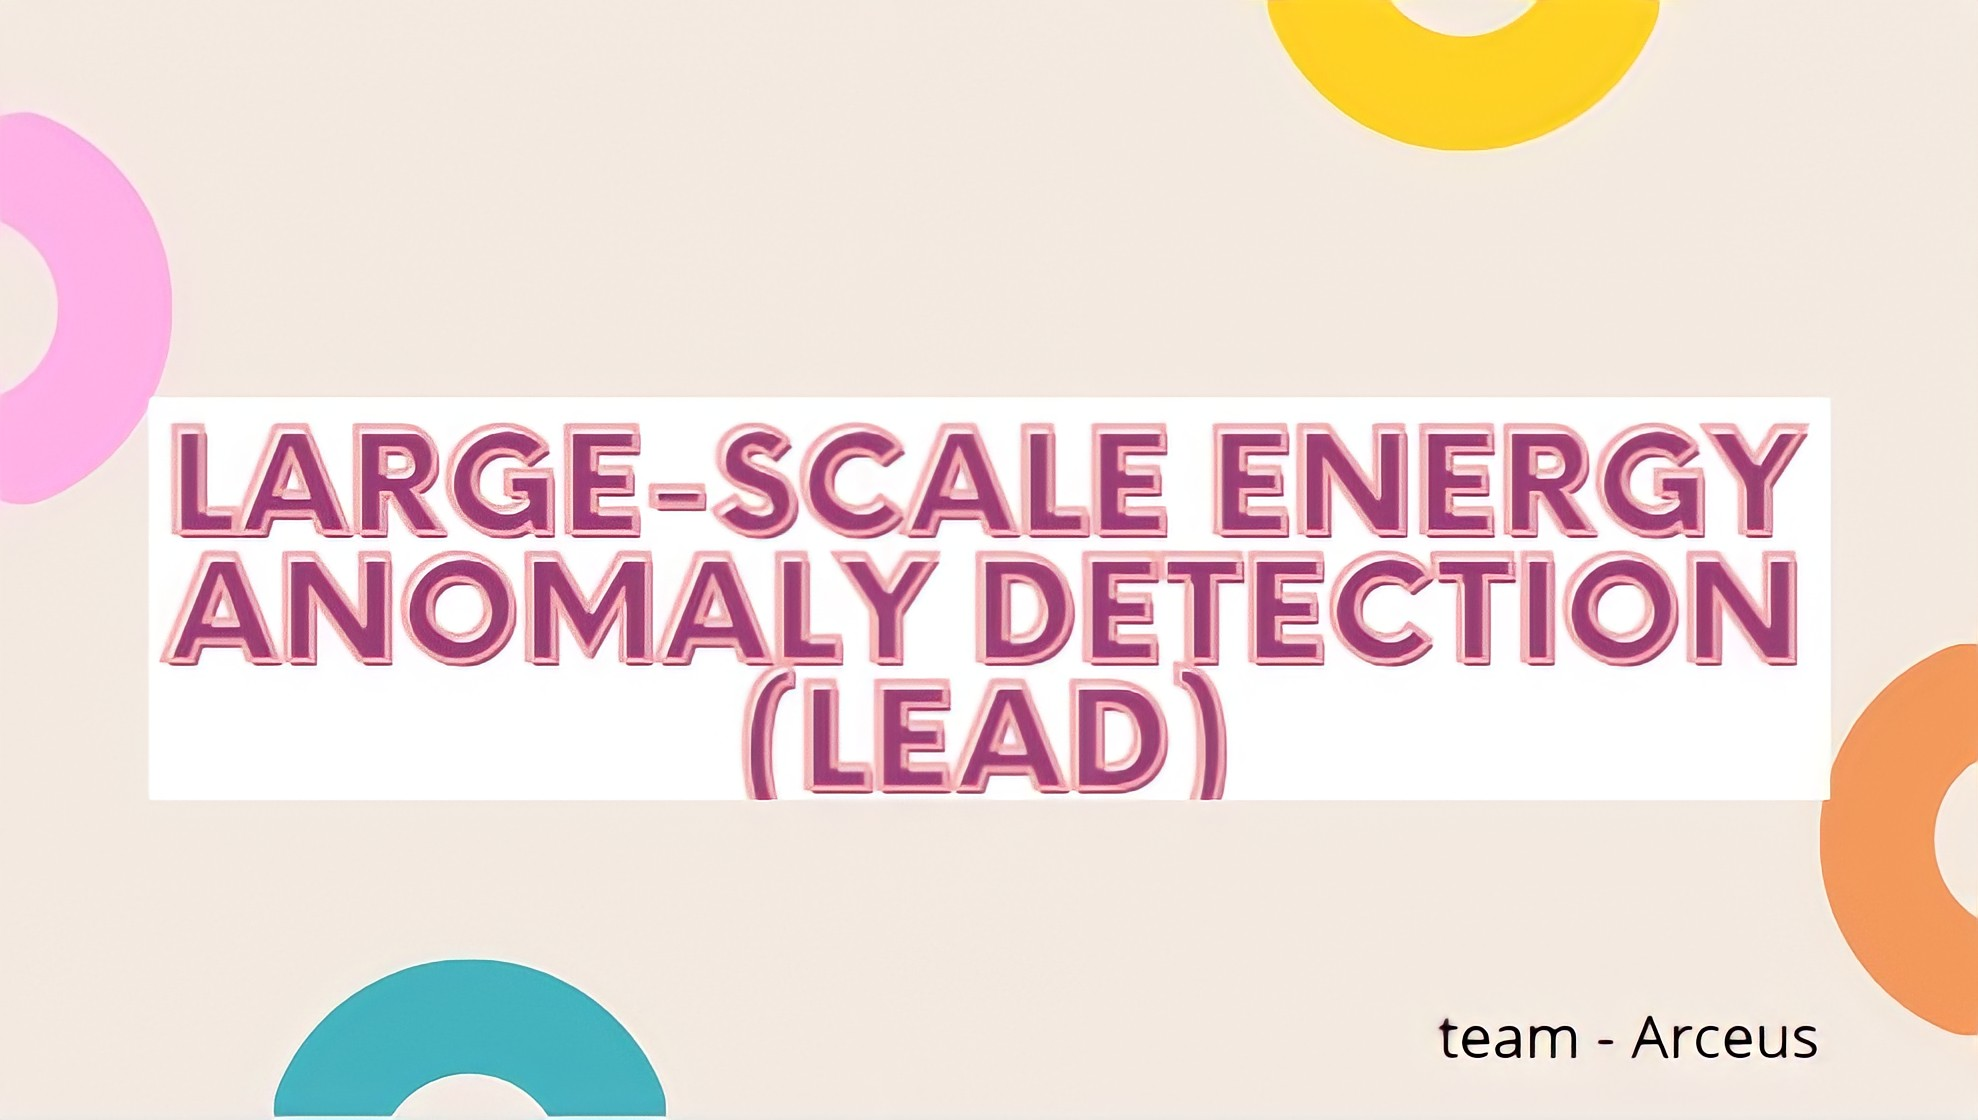
# Introduction:

Anomaly detection is the process of detecting unexpected events or  points  at 
 this position of the data set, or deviate from the normal sample of the data set. 
 As such, detecting these points is very important; because it gives us the first step to take 
 urgent movements to control this abnormal change. 
 We used a variety of techniques to find the best one to apply to our project roadmap.
 
# Anomaly Detection Methods: 
The outlairs and anomaly detection different methods:

<li><a href="#m1">1- Tukey’s box plot method</a>
<li><a href="#m2">2- Isolation forest.</a>
<li><a href="#m3">3- Anomly based on Machine learning Predication.</a>

In [ ]:
import pandas as pd
import numpy as np
import plotly.express as px
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
from datetime import datetime, timezone
import datetime
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import plotly.express as px
import plotly.graph_objects as go
warnings.filterwarnings('ignore')

In [ ]:
!pip3 install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
df = pd.read_csv('/content/train-2.csv',parse_dates= ["timestamp"])

In [ ]:
df_name = df.iloc[:,[0,2]].columns

In [ ]:

# there is a problem with missing values so i will try to handel it.

from sklearn.impute import SimpleImputer

my_imputer = SimpleImputer()
df_clean = my_imputer.fit_transform(df.iloc[:,[0,2]])

df_clean = pd.DataFrame(df_clean,columns = df_name)

missing_val_count_by_column = (df_clean.isnull().sum())
print(missing_val_count_by_column)

building_id      0
meter_reading    0
dtype: int64


In [ ]:
df.iloc[:,[1,3]].shape

(1749494, 2)

In [ ]:
df_clean.shape

(1749494, 2)

In [ ]:
df = pd.concat([df.iloc[:,[1,3]], df_clean], axis=1)


In [ ]:
df.head()

,timestamp,anomaly,building_id,meter_reading
0,2016-01-01,0,1.0,179.901838
1,2016-01-01,0,32.0,179.901838
2,2016-01-01,0,41.0,179.901838
3,2016-01-01,0,55.0,179.901838
4,2016-01-01,0,69.0,179.901838


In [ ]:
df.columns

Index(['timestamp', 'anomaly', 'building_id', 'meter_reading'], dtype='object')

In [ ]:
df = df[['timestamp',  'building_id', 'meter_reading','anomaly']]

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1749494 entries, 0 to 1749493
Data columns (total 4 columns):
 #   Column         Dtype         
---  ------         -----         
 0   timestamp      datetime64[ns]
 1   building_id    float64       
 2   meter_reading  float64       
 3   anomaly        int64         
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 53.4 MB


In [ ]:
df['building_id'] = df['building_id'].apply(np.int64)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1749494 entries, 0 to 1749493
Data columns (total 4 columns):
 #   Column         Dtype         
---  ------         -----         
 0   timestamp      datetime64[ns]
 1   building_id    int64         
 2   meter_reading  float64       
 3   anomaly        int64         
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 53.4 MB


## <h3> 1- Tukey’s box plot method</h3>
<a id="m1"></a>


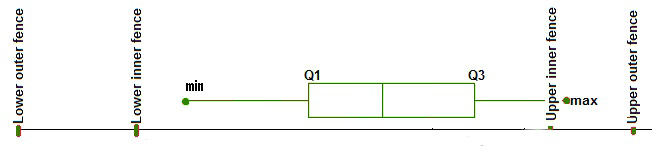

#### First apply on a random grid

In [ ]:
df.columns

Index(['timestamp', 'building_id', 'meter_reading', 'anomaly'], dtype='object')

In [ ]:
df['building_id'].value_counts()

1       8784
1278    8784
1283    8784
1284    8784
1285    8784
        ... 
848     8351
844     7959
827     7799
1232    7779
1353    7471
Name: building_id, Length: 200, dtype: int64

In [ ]:
df.set_index('timestamp',inplace=True)

In [ ]:
df.groupby("building_id").get_group(108)

,building_id,meter_reading,anomaly
timestamp,,,
2016-01-01 00:00:00,108,179.901838,0
2016-01-01 01:00:00,108,182.531000,1
2016-01-01 02:00:00,108,1.000000,1
2016-01-01 03:00:00,108,1.000000,1
2016-01-01 04:00:00,108,1.000000,1
...,...,...,...
2016-12-31 19:00:00,108,179.500000,0
2016-12-31 20:00:00,108,178.000000,0
2016-12-31 21:00:00,108,176.500000,0


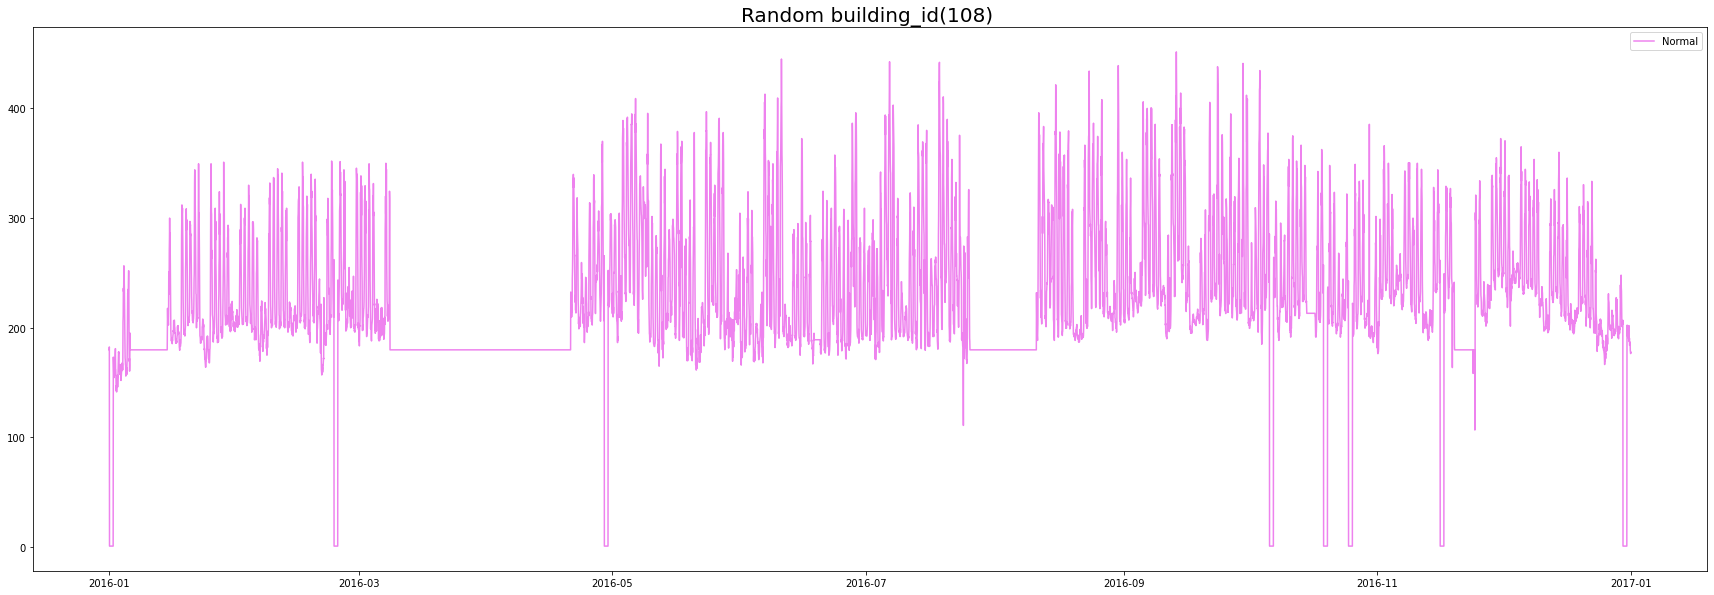

In [ ]:
fig, ax = plt.subplots(figsize=(30,10))
ax.plot(df.groupby("building_id").get_group(108)['meter_reading'].index, 
        df.groupby("building_id").get_group(108)['meter_reading'], color='Violet', label = 'Normal')
ax.set_title('Random building_id(108) ', fontsize=20)
plt.legend()
plt.show();

In [ ]:
def tukeys_method(df, variable):
    #Takes two parameters: dataframe & variable of interest as string
    q1 = df[variable].quantile(0.25)
    q3 = df[variable].quantile(0.75)
    iqr = q3-q1
    inner_fence = 1.5*iqr
    outer_fence = 3*iqr
    
    #inner fence lower and upper end
    inner_fence_le = q1-inner_fence
    inner_fence_ue = q3+inner_fence
    
    #outer fence lower and upper end
    outer_fence_le = q1-outer_fence
    outer_fence_ue = q3+outer_fence
    
    outliers_prob = []
    outliers_poss = []
    for index, x in enumerate(df[variable]):
        if x <= outer_fence_le or x >= outer_fence_ue:
            outliers_prob.append(index)
    for index, x in enumerate(df[variable]):
        if x <= inner_fence_le or x >= inner_fence_ue:
            outliers_poss.append(index)
    return outliers_prob, outliers_poss


In [ ]:
random_building_id = df.groupby("building_id").get_group(108)

probable_outliers_tm, possible_outliers_tm = tukeys_method(random_building_id, "meter_reading")

print(probable_outliers_tm)
print("_________________________________________________________________________________")
print(possible_outliers_tm)

[]
_________________________________________________________________________________
[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 1298, 1299, 1300, 1301, 1302, 1303, 1304, 1305, 1306, 1307, 1308, 1309, 1310, 1311, 1312, 1313, 1314, 1315, 1316, 1317, 1318, 1319, 2858, 2859, 2860, 2861, 2862, 2863, 2864, 2865, 2866, 2867, 2868, 2869, 2870, 2871, 2872, 2873, 2874, 2875, 2876, 2877, 2878, 2879, 2964, 2965, 2968, 2988, 2989, 2990, 2991, 2992, 3013, 3014, 3015, 3016, 3017, 3035, 3036, 3037, 3038, 3039, 3040, 3108, 3280, 3377, 3445, 3446, 3447, 3448, 3449, 3518, 3519, 3520, 3521, 3544, 3780, 3782, 3783, 3784, 3785, 3786, 3857, 3858, 3877, 3878, 3879, 3880, 3881, 3882, 4289, 4290, 4308, 4309, 4310, 4311, 4312, 4479, 4480, 4481, 4499, 4500, 4501, 4502, 4503, 4504, 4505, 4506, 4524, 4525, 4526, 4527, 4528, 4669, 4718, 4789, 4790, 4791, 4792, 4793, 4794, 4813, 4814, 4815, 4837, 4908, 5365, 5369, 5393, 5460, 5461, 5462, 5463, 5464, 5465, 5487, 5537, 5653, 5654, 

In [ ]:
len(probable_outliers_tm)

0

In [ ]:
len(possible_outliers_tm)

352

In [ ]:
anomaly = pd.DataFrame(possible_outliers_tm)
anomaly['Anomaly'] = 1
anomaly.set_index(0, inplace=True)

In [ ]:
random_building_id = pd.concat([random_building_id.reset_index(), anomaly], axis=1)

In [ ]:
random_building_id

,timestamp,building_id,meter_reading,anomaly,Anomaly
0,2016-01-01 00:00:00,108,179.901838,0,NaN
1,2016-01-01 01:00:00,108,182.531000,1,NaN
2,2016-01-01 02:00:00,108,1.000000,1,1.0
3,2016-01-01 03:00:00,108,1.000000,1,1.0
4,2016-01-01 04:00:00,108,1.000000,1,1.0
...,...,...,...,...,...
8779,2016-12-31 19:00:00,108,179.500000,0,NaN
8780,2016-12-31 20:00:00,108,178.000000,0,NaN
8781,2016-12-31 21:00:00,108,176.500000,0,NaN
8782,2016-12-31 22:00:00,108,178.000000,0,NaN


In [ ]:
random_building_id['Anomaly'] = random_building_id['Anomaly'].replace(np.nan, False)
random_building_id['Anomaly'] = random_building_id['Anomaly'].replace(1.0, True)

In [ ]:
random_building_id['Anomaly'].value_counts()

False    8432
True      352
Name: Anomaly, dtype: int64

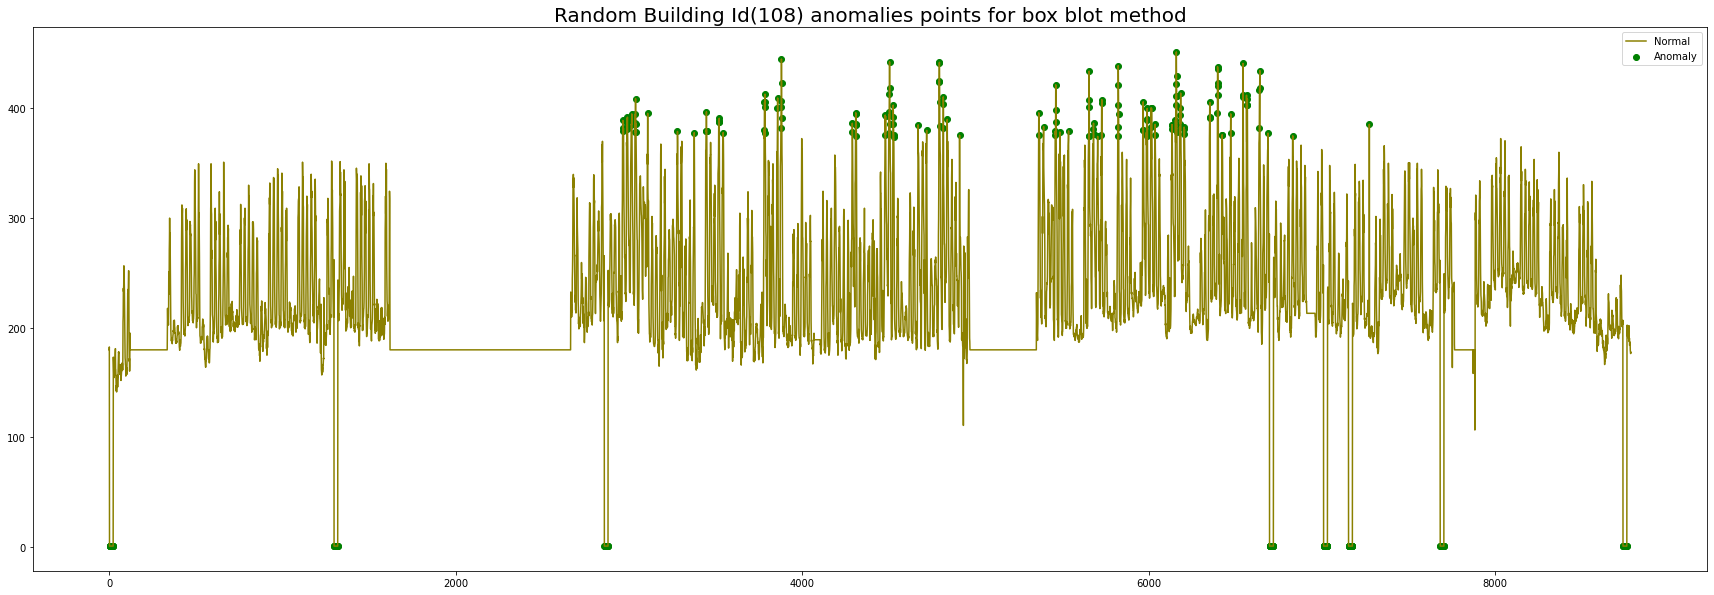

In [ ]:
fig, ax = plt.subplots(figsize=(30,10))

anomaly = random_building_id.loc[random_building_id['Anomaly'] == True, ['meter_reading']] 

ax.plot(random_building_id.index, random_building_id['meter_reading'], color='#8B8000', label = 'Normal')
ax.scatter(anomaly.index,anomaly['meter_reading'], color='green', label = 'Anomaly')
ax.set_title('Random Building Id(108) anomalies points for box blot method', fontsize=20)
plt.legend()
plt.show();

In [ ]:
# fig1 = px.line(random_building_id,  y="meter_reading")
# fig1.update_traces(line=dict(color = 'magenta'))

# anomaly = random_building_id.loc[random_building_id['Anomaly'] == True, ['meter_reading']] 
# fig2 = px.scatter(anomaly,y="meter_reading")

# fig3 = go.Figure(data=fig1.data + fig2.data)
# fig3.update_layout(title="Random Building Id(108) anomalies points for box blot method")
# fig3.show()

In [ ]:
print("The prediction model has an accracy of: ",round((random_building_id[random_building_id['anomaly'] == random_building_id['Anomaly']].shape[0]/random_building_id.shape[0])*100,2),"%")

The prediction model has an accracy of:  96.69 %


#### Second apply on all grids

In [ ]:
All_buildings = df.groupby("building_id")
buildings = list(All_buildings.groups.keys())

In [ ]:
data=[]
for building in buildings:
    All_buildings = df.groupby("building_id").get_group(building)
    data.append(All_buildings)

In [ ]:
x=len(buildings)
x

200

In [ ]:
buildings

[1,
 32,
 41,
 55,
 69,
 79,
 82,
 91,
 107,
 108,
 111,
 112,
 117,
 118,
 119,
 121,
 136,
 137,
 139,
 141,
 144,
 147,
 148,
 149,
 159,
 171,
 173,
 174,
 181,
 183,
 190,
 235,
 238,
 240,
 246,
 247,
 248,
 253,
 254,
 263,
 270,
 275,
 276,
 278,
 290,
 293,
 312,
 318,
 335,
 345,
 356,
 423,
 439,
 492,
 534,
 560,
 623,
 653,
 657,
 658,
 666,
 667,
 673,
 675,
 677,
 680,
 683,
 685,
 687,
 693,
 697,
 698,
 701,
 708,
 710,
 721,
 722,
 729,
 730,
 732,
 739,
 742,
 801,
 827,
 844,
 848,
 879,
 880,
 881,
 882,
 884,
 886,
 887,
 889,
 890,
 892,
 893,
 894,
 895,
 896,
 903,
 905,
 909,
 914,
 919,
 922,
 924,
 925,
 926,
 928,
 929,
 931,
 935,
 936,
 941,
 942,
 945,
 948,
 950,
 952,
 961,
 966,
 967,
 968,
 969,
 970,
 971,
 973,
 974,
 975,
 977,
 978,
 981,
 988,
 990,
 992,
 994,
 996,
 1001,
 1007,
 1068,
 1073,
 1074,
 1106,
 1120,
 1128,
 1137,
 1141,
 1143,
 1147,
 1172,
 1219,
 1225,
 1226,
 1230,
 1232,
 1234,
 1238,
 1239,
 1241,
 1242,
 1245,
 1246,
 1247,

In [ ]:
# test Tukey’s box plot method

data_2=pd.DataFrame()
anomalies= pd.DataFrame()
for i in range(x):
    probable_outliers_tm, possible_outliers_tm = tukeys_method(data[i], "meter_reading")
    
    if len(possible_outliers_tm)==0:
        print("________________ NO Anomaly in building number {} ________________".format(i+1))
        print("__________________________________________________________________")
        anomaly = pd.DataFrame(possible_outliers_tm)
        data_2 = pd.concat([data[i].reset_index(drop=True), anomaly], axis=1)
        anomalies=anomalies.append(data_2)
        continue

    
    anomaly = pd.DataFrame(possible_outliers_tm)
    anomaly['Anomaly'] = 1
    anomaly.set_index(0, inplace=True)

    data_2 = pd.concat([data[i].reset_index(drop=True), anomaly], axis=1)
    
    print("_______________ building number {} done ________________".format(i+1))

    print("-" *14,"have number of anomalies points ",data_2['Anomaly'].value_counts().index[0],"-" *14)
    print("__________________________________________________________")
    
    anomalies=anomalies.append(data_2)
    #print(data_2)
    #print(anomalies)

________________ NO Anomaly in building number 1 ________________
__________________________________________________________________
________________ NO Anomaly in building number 2 ________________
__________________________________________________________________
________________ NO Anomaly in building number 3 ________________
__________________________________________________________________
________________ NO Anomaly in building number 4 ________________
__________________________________________________________________
________________ NO Anomaly in building number 5 ________________
__________________________________________________________________
_______________ building number 6 done ________________
-------------- have number of anomalies points  1.0 --------------
__________________________________________________________
________________ NO Anomaly in building number 7 ________________
__________________________________________________________________
_______________ buil

check if the results are true

In [ ]:
anomalies.shape

(1749494, 4)

In [ ]:
df.shape

(1749494, 3)

In [ ]:
anomalies.groupby("building_id").get_group(1323)["Anomaly"].value_counts()

1.0    148
Name: Anomaly, dtype: int64

In [ ]:
anomalies.groupby("building_id").get_group(1007)["Anomaly"].value_counts()

1.0    318
Name: Anomaly, dtype: int64

In [ ]:
df.groupby("building_id").get_group(1007).shape

(8649, 3)

In [ ]:
anomalies.groupby("building_id").get_group(1007).shape

(8649, 4)

In [ ]:
anomalies.reset_index(drop=True,inplace=True)

In [ ]:
anomalies['Anomaly'] = anomalies['Anomaly'].replace(np.nan, False)
anomalies['Anomaly'] = anomalies['Anomaly'].replace(1.0, True)

In [ ]:
anomalies['Anomaly'].value_counts()

False    1679890
True       69604
Name: Anomaly, dtype: int64

In [ ]:
anomalies['anomaly'].value_counts()

0    1712198
1      37296
Name: anomaly, dtype: int64

In [ ]:
anomalies['anomaly'] = anomalies['anomaly'].replace(0, False)
anomalies['anomaly'] = anomalies['anomaly'].replace(1, True)

In [ ]:
anomalies['anomaly'].value_counts()

False    1712198
True       37296
Name: anomaly, dtype: int64

In [ ]:
# fig, ax = plt.subplots(figsize=(30,10))
# ax.plot(df.index, df['meter_reading'], color='blue', label = 'Normal')
# ax.set_title('Total grids', fontsize=20)
# plt.show();

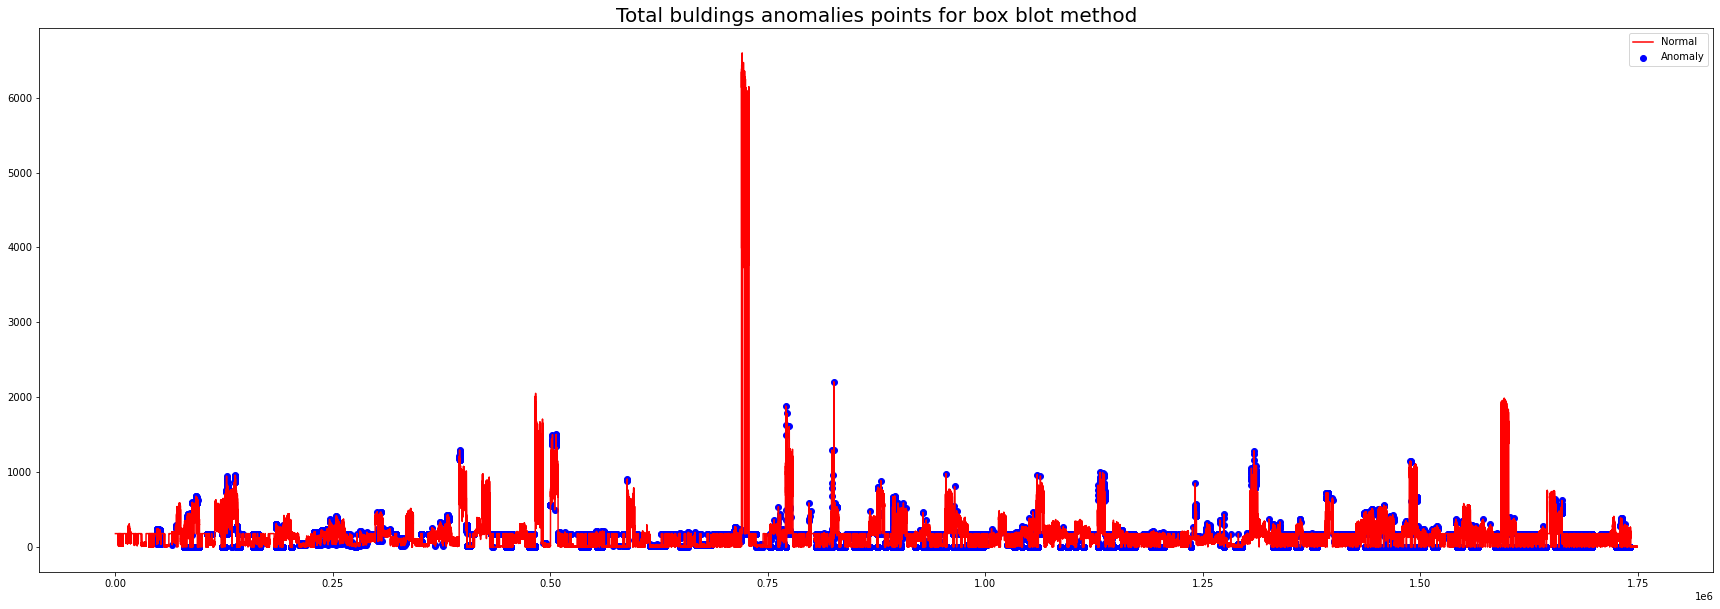

In [ ]:
fig, ax = plt.subplots(figsize=(30,10))

anomaly = anomalies.loc[anomalies['Anomaly'] == True, ['meter_reading']] 

ax.plot(anomalies.index, anomalies['meter_reading'], color='red', label = 'Normal')
ax.scatter(anomaly.index,anomaly['meter_reading'], color='blue', label = 'Anomaly')
ax.set_title('Total buldings anomalies points for box blot method', fontsize=20)
plt.legend()
plt.show();

In [ ]:
# fig1 = px.line(df,  y="meter_reading")
# fig1.update_traces(line=dict(color = 'rgba(250,100,10,0.2)'))
# anomaly = anomalies.loc[anomalies['Anomaly'] == -1, ['meter_reading']] 

# fig2 = px.scatter(anomaly,y='meter_reading')

# fig3 = go.Figure(data=fig1.data + fig2.data)
# fig3.update_layout(title="Total buldings anomalies points for isolation forest")
# fig3.show()

In [ ]:
print("my first model predication has accurcy ",round((anomalies[anomalies['anomaly'] == anomalies['Anomaly']].shape[0]/anomalies.shape[0])*100,2),"%")

my first model predication has accurcy  95.05 %


## <h3> 2- Isolation forest.</h3>
<a id="m2"></a>

This method relies on detection using several machine learning algorithms. among them 
 It depends on the isolation forest. 
 
 One of these algorithms is the IsolationForest method. Isolation forest construction by decision 
 Trees that depend on deeper points in the tree are not anomalies or points 
 Traveling short distances is unusual and is likely to be  unsupervised learning. 
 Models used without labeled data. 
 
 The algorithm selects a sample of the dataset and branches it with a binary streak. 
 If you set a threshold, if the selected sample  is less than this threshold, it will be displayed on the left. 
 Branch to the right branch otherwise. This process repeats until each point is reached 
 The records are separated.

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest

#### First apply on a random grid

In [ ]:
random_building_id = df.groupby("building_id").get_group(108)
random_building_id.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8784 entries, 2016-01-01 00:00:00 to 2016-12-31 23:00:00
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   building_id    8784 non-null   int64  
 1   meter_reading  8784 non-null   float64
 2   anomaly        8784 non-null   int64  
dtypes: float64(1), int64(2)
memory usage: 274.5 KB


In [ ]:
# train isolation forest
outliers_fraction = float(.01)
scaler = StandardScaler()
np_scaled = scaler.fit_transform(random_building_id["meter_reading"].values.reshape(-1, 1))
df_data = pd.DataFrame(np_scaled)

model =  IsolationForest(contamination=outliers_fraction)
model.fit(df_data) 

IsolationForest(contamination=0.01)

In [ ]:
# predict isolation forest
Anomaly = model.predict(df_data)

In [ ]:
Anomaly = pd.DataFrame(Anomaly,columns=['Anomaly'])
Anomaly

,Anomaly
0,1
1,1
2,1
3,1
4,1
...,...
8779,1
8780,1
8781,1
8782,1


In [ ]:
random_building_id = pd.concat([random_building_id.reset_index(), Anomaly], axis=1)
random_building_id

,timestamp,building_id,meter_reading,anomaly,Anomaly
0,2016-01-01 00:00:00,108,179.901838,0,1
1,2016-01-01 01:00:00,108,182.531000,1,1
2,2016-01-01 02:00:00,108,1.000000,1,1
3,2016-01-01 03:00:00,108,1.000000,1,1
4,2016-01-01 04:00:00,108,1.000000,1,1
...,...,...,...,...,...
8779,2016-12-31 19:00:00,108,179.500000,0,1
8780,2016-12-31 20:00:00,108,178.000000,0,1
8781,2016-12-31 21:00:00,108,176.500000,0,1
8782,2016-12-31 22:00:00,108,178.000000,0,1


In [ ]:
random_building_id['Anomaly'].value_counts()

1    8784
Name: Anomaly, dtype: int64

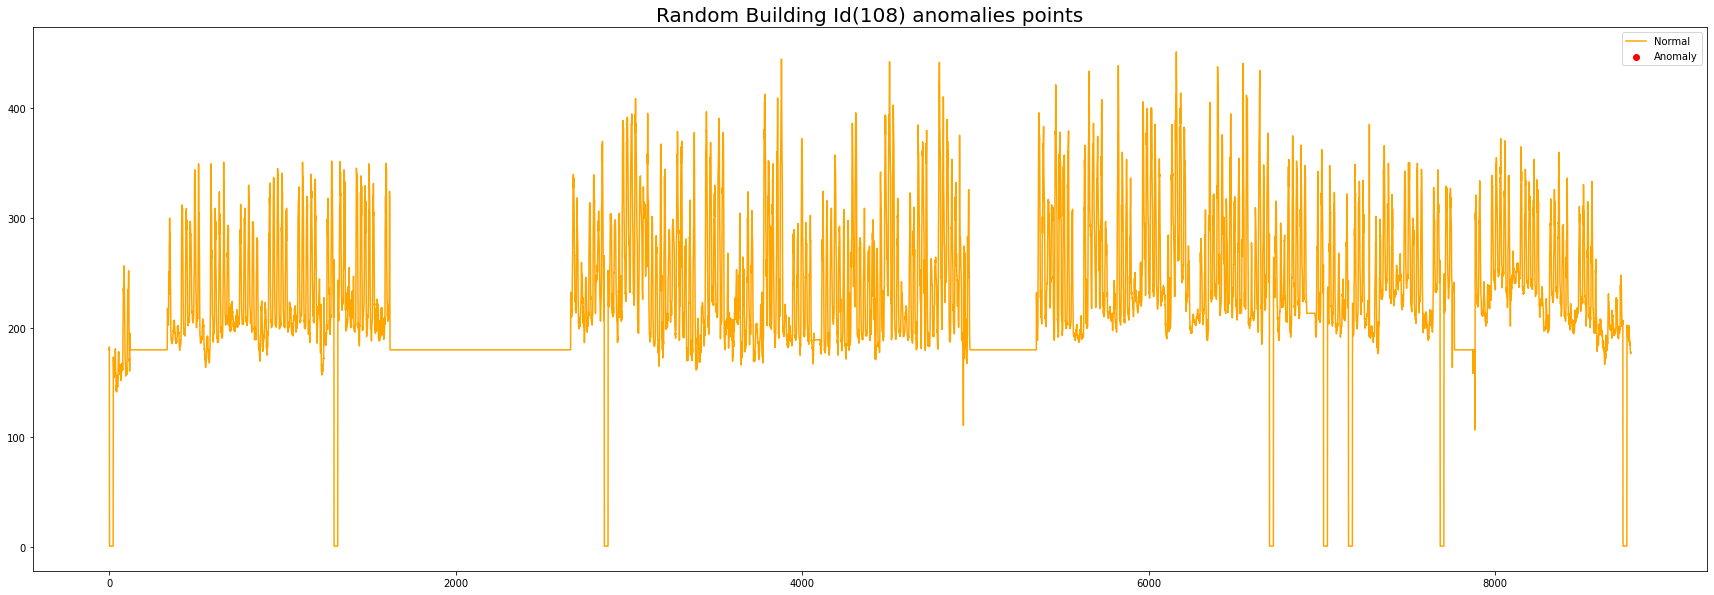

In [ ]:

fig, ax = plt.subplots(figsize=(30,10))

anomaly = random_building_id.loc[random_building_id['Anomaly'] == -1, ['meter_reading']] 

ax.plot(random_building_id.index, random_building_id['meter_reading'], color='orange', label = 'Normal')
ax.scatter(anomaly.index,anomaly['meter_reading'], color='red', label = 'Anomaly')
ax.set_title('Random Building Id(108) anomalies points', fontsize=20)
plt.legend()
plt.show();

In [ ]:
random_building_id['Anomaly'].value_counts()

1    8784
Name: Anomaly, dtype: int64

In [ ]:
random_building_id['Anomaly'] = random_building_id['Anomaly'].replace(1, 0)
random_building_id['Anomaly'] = random_building_id['Anomaly'].replace(-1, 1)

In [ ]:
print("my first model predication for only one building has accurcy ",round((random_building_id[random_building_id['anomaly'] == random_building_id['Anomaly']].shape[0]/random_building_id.shape[0])*100,2),"%")

my first model predication for only one building has accurcy  96.57 %


#### Second apply on all grids 

In [ ]:
data=[]
for building in buildings:
    All_buildings = df.groupby("building_id").get_group(building)
    data.append(All_buildings)
#data

In [ ]:
data[0]

,building_id,meter_reading,anomaly
timestamp,,,
2016-01-01 00:00:00,1,179.901838,0
2016-01-01 01:00:00,1,179.901838,0
2016-01-01 02:00:00,1,179.901838,0
2016-01-01 03:00:00,1,179.901838,0
2016-01-01 04:00:00,1,179.901838,0
...,...,...,...
2016-12-31 19:00:00,1,20.006000,0
2016-12-31 20:00:00,1,15.364000,0
2016-12-31 21:00:00,1,15.685000,0


In [ ]:
# train isolation forest
full_anomaly = pd.DataFrame()
for i in range (x):
    
    All_buildings = data[i]
    
    outliers_fraction = float(.01)

    scaler = StandardScaler()
    np_scaled = scaler.fit_transform(All_buildings["meter_reading"].values.reshape(-1, 1))
    df_data = pd.DataFrame(np_scaled)

    model =  IsolationForest(contamination=outliers_fraction)
    model.fit(df_data) 
    Anomaly = model.predict(df_data)
    Anomaly = pd.DataFrame(Anomaly,columns=['Anomaly'])
    print("__________ building number {} predicted __________".format(i+1))
    full_anomaly = full_anomaly.append(Anomaly)

__________ building number 1 predicted __________
__________ building number 2 predicted __________
__________ building number 3 predicted __________
__________ building number 4 predicted __________
__________ building number 5 predicted __________
__________ building number 6 predicted __________
__________ building number 7 predicted __________
__________ building number 8 predicted __________
__________ building number 9 predicted __________
__________ building number 10 predicted __________
__________ building number 11 predicted __________
__________ building number 12 predicted __________
__________ building number 13 predicted __________
__________ building number 14 predicted __________
__________ building number 15 predicted __________
__________ building number 16 predicted __________
__________ building number 17 predicted __________
__________ building number 18 predicted __________
__________ building number 19 predicted __________
__________ building number 20 predicted 

In [ ]:
full_anomaly.reset_index(inplace= True)
full_anomaly.drop('index', axis=1, inplace=True)
full_anomaly

,Anomaly
0,1
1,1
2,1
3,1
4,1
...,...
1749489,1
1749490,1
1749491,1
1749492,1


In [ ]:
df_full_anomaly = pd.concat([df.reset_index(), full_anomaly], axis=1)
df_full_anomaly

,timestamp,building_id,meter_reading,anomaly,Anomaly
0,2016-01-01 00:00:00,1,179.901838,0,1
1,2016-01-01 00:00:00,32,179.901838,0,1
2,2016-01-01 00:00:00,41,179.901838,0,1
3,2016-01-01 00:00:00,55,179.901838,0,1
4,2016-01-01 00:00:00,69,179.901838,0,1
...,...,...,...,...,...
1749489,2016-12-31 23:00:00,1316,38.844000,0,1
1749490,2016-12-31 23:00:00,1318,202.893000,0,1
1749491,2016-12-31 23:00:00,1319,179.901838,0,1
1749492,2016-12-31 23:00:00,1323,172.000000,0,1


In [ ]:
# fig1 = px.line(df_full_anomaly,  y="meter_reading")
# fig1.update_traces(line=dict(color = 'rgba(250,100,10,0.2)'))
# fig1.update_layout(title="Total buildings")
# fig1.show()

In [ ]:
# fig1 = px.line(df_full_anomaly,  y="meter_reading")
# fig1.update_traces(line=dict(color = 'rgba(250,100,10,0.2)'))
# anomaly = df_full_anomaly.loc[df_full_anomaly['Anomaly'] == -1, ['meter_reading']] 

# fig2 = px.scatter(anomaly,y='meter_reading')

# fig3 = go.Figure(data=fig1.data + fig2.data)
# fig3.update_layout(title="Total buildings anomalies points for isolation forest")
# fig3.show()

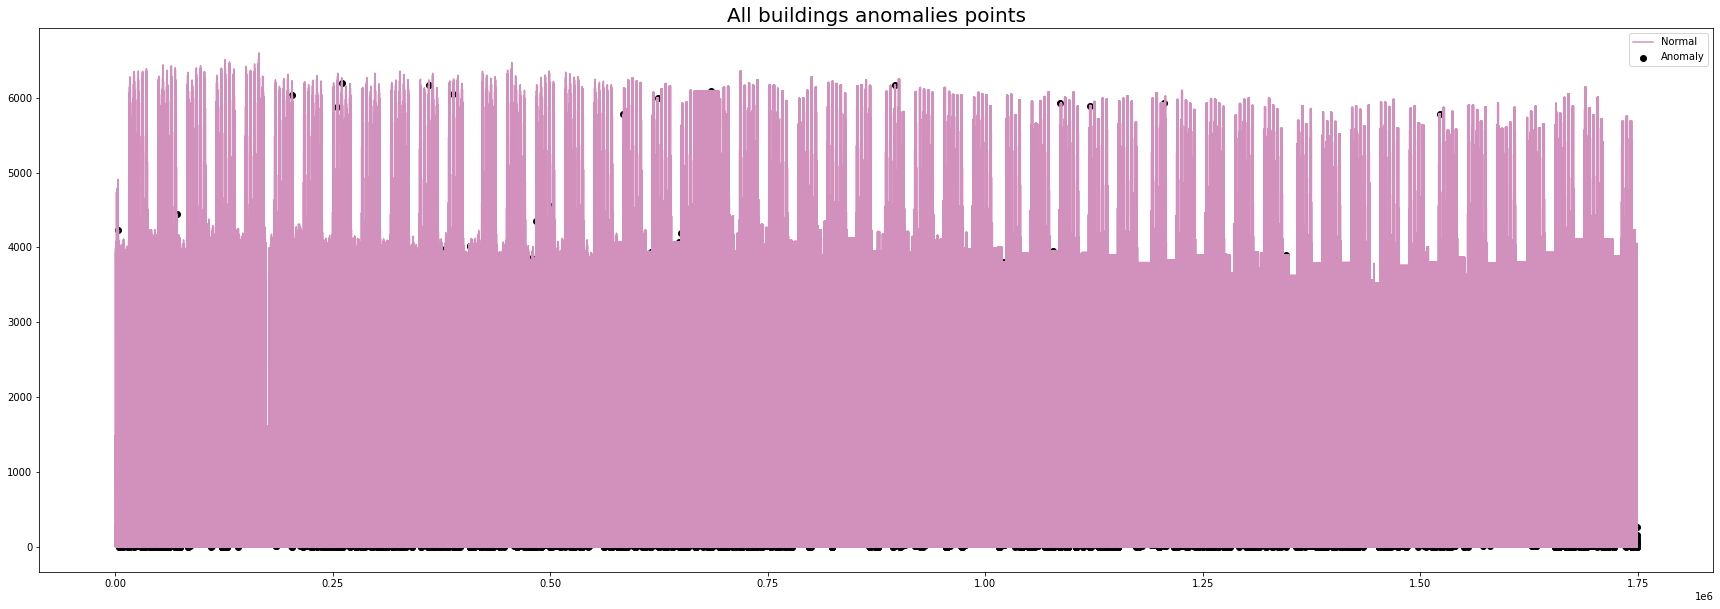

In [ ]:

fig, ax = plt.subplots(figsize=(30,10))

anomaly = df_full_anomaly.loc[df_full_anomaly['Anomaly'] == -1, ['meter_reading']] 

ax.plot(df_full_anomaly.index, df_full_anomaly['meter_reading'], color='#D291BC', label = 'Normal')
ax.scatter(anomaly.index,anomaly['meter_reading'], color='black', label = 'Anomaly')
ax.set_title('All buildings anomalies points', fontsize=20)
plt.legend()
plt.show();

In [ ]:
df_full_anomaly['Anomaly'].value_counts()

0    1749494
Name: Anomaly, dtype: int64

In [ ]:
df_full_anomaly['Anomaly'] = df_full_anomaly['Anomaly'].replace(1, 0)
df_full_anomaly['Anomaly'] = df_full_anomaly['Anomaly'].replace(-1, 1)

In [ ]:
print("my first model predication for only one building has accurcy ",round((df_full_anomaly[df_full_anomaly['anomaly'] == df_full_anomaly['Anomaly']].shape[0]/df.shape[0])*100,2),"%")

my first model predication for only one building has accurcy  97.87 %


<h3> 3- Anomly based on Machine learning Predication.</h3>
<a id="m3"></a>

In [ ]:
# Load libraries

from pandas import set_option
from pandas.plotting import scatter_matrix

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

SEED = 7
np.random.seed(SEED)

In [ ]:
!gdown  https://drive.google.com/file/d/19gbGBG7Ta0jjFuah-9tvr79-xiu2mFtJ/view?usp=sharing
!gdown  https://drive.google.com/file/d/1FEluwcBE7-wACs9oqWbkre6XKNme5T6e/view?usp=sharing

/usr/local/lib/python3.7/dist-packages/gdown/parse_url.py:39: UserWarning: You specified a Google Drive link that is not the correct link to download a file. You might want to try `--fuzzy` option or the following url: https://drive.google.com/uc?id=19gbGBG7Ta0jjFuah-9tvr79-xiu2mFtJ
  url="https://drive.google.com/uc?id={}".format(file_id)
Downloading...
From: https://drive.google.com/file/d/19gbGBG7Ta0jjFuah-9tvr79-xiu2mFtJ/view?usp=sharing
To: /content/view?usp=sharing
69.5kB [00:00, 14.2MB/s]
/usr/local/lib/python3.7/dist-packages/gdown/parse_url.py:39: UserWarning: You specified a Google Drive link that is not the correct link to download a file. You might want to try `--fuzzy` option or the following url: https://drive.google.com/uc?id=1FEluwcBE7-wACs9oqWbkre6XKNme5T6e
  url="https://drive.google.com/uc?id={}".format(file_id)
Downloading...
From: https://drive.google.com/file/d/1FEluwcBE7-wACs9oqWbkre6XKNme5T6e/view?usp=sharing
To: /content/view?usp=sharing
69.5kB [00:00, 3.50MB/s

In [ ]:
train = pd.read_csv('/content/train_features.csv')
test = pd.read_csv('/content/test_features.csv')

#take sample to test the code quickly
# train = train.iloc[:train.shape[0]//1500,:]
# test = test.iloc[:test.shape[0]//1500,:]


In [ ]:
train.head()

,building_id,timestamp,meter_reading,anomaly,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,...,gte_meter,gte_meter_hour,gte_meter_weekday,gte_meter_month,gte_meter_building_id,gte_meter_primary_use,gte_meter_site_id,gte_meter_building_id_hour,gte_meter_building_id_weekday,gte_meter_building_id_month
0,1,2016-01-01 00:00:00,NaN,0,0,Education,2720,104,0,19.4,...,4.116,3.981,4.146,4.12,3.569,4.489,4.079,3.554,3.538,3.845
1,32,2016-01-01 00:00:00,NaN,0,0,Office,48392,105,0,19.4,...,4.116,3.981,4.146,4.12,4.513,4.211,4.079,4.128,4.579,4.317
2,41,2016-01-01 00:00:00,NaN,0,0,Office,93860,68,0,19.4,...,4.116,3.981,4.146,4.12,4.108,4.211,4.079,4.103,4.140,4.114
3,55,2016-01-01 00:00:00,NaN,0,0,Office,16726,111,0,19.4,...,4.116,3.981,4.146,4.12,3.506,4.211,4.079,3.308,3.565,3.813
4,69,2016-01-01 00:00:00,NaN,0,0,Parking,387638,100,0,19.4,...,4.116,3.981,4.146,4.12,3.035,3.623,4.079,3.892,3.090,3.577


In [ ]:
train.shape

(1749494, 57)

### Feature Engineering

take only important features

In [ ]:
train.columns

Index(['building_id', 'timestamp', 'meter_reading', 'anomaly', 'site_id',
       'primary_use', 'square_feet', 'year_built', 'floor_count',
       'air_temperature', 'cloud_coverage', 'dew_temperature',
       'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction',
       'wind_speed', 'air_temperature_mean_lag7', 'air_temperature_max_lag7',
       'air_temperature_min_lag7', 'air_temperature_std_lag7',
       'air_temperature_mean_lag73', 'air_temperature_max_lag73',
       'air_temperature_min_lag73', 'air_temperature_std_lag73', 'hour',
       'weekday', 'month', 'year', 'weekday_hour', 'hour_x', 'hour_y',
       'month_x', 'month_y', 'weekday_x', 'weekday_y', 'building_weekday_hour',
       'building_weekday', 'building_month', 'building_hour', 'building_meter',
       'is_holiday', 'gte_hour', 'gte_weekday', 'gte_month', 'gte_building_id',
       'gte_primary_use', 'gte_site_id', 'gte_meter', 'gte_meter_hour',
       'gte_meter_weekday', 'gte_meter_month', 'gte_meter_building

In [ ]:
train = train[['building_id', 'meter_reading', 'square_feet',
       'year_built', 'floor_count','air_temperature', 'dew_temperature',
       'precip_depth_1_hr', 'sea_level_pressure','is_holiday','anomaly']]

test = test[['building_id',  'meter_reading','square_feet',
       'year_built', 'floor_count','air_temperature', 'dew_temperature',
       'precip_depth_1_hr', 'sea_level_pressure','is_holiday']]

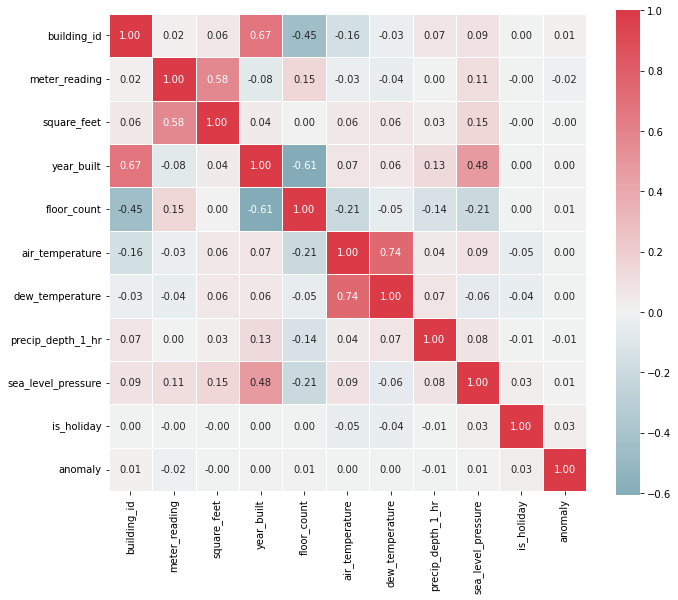

In [ ]:
def HeatMap(df,x=True):
        correlations = df.corr()
        ## Create color map ranging between two colors
        cmap = sns.diverging_palette(220, 10, as_cmap=True)
        fig, ax = plt.subplots(figsize=(10, 10))
        fig = sns.heatmap(correlations, cmap=cmap, vmax=1.0, center=0, fmt='.2f',square=True, linewidths=.5, annot=x, cbar_kws={"shrink": .75})
        fig.set_xticklabels(fig.get_xticklabels(), rotation = 90, fontsize = 10)
        fig.set_yticklabels(fig.get_yticklabels(), rotation = 0, fontsize = 10)
        plt.tight_layout()
        plt.show()

HeatMap(train,x=True)

 There is no highly corrolated feature in the data set to remove it.

there is a problem with missing values so i will try to handel it.

In [ ]:
missing_val_count_by_column = (train.isnull().sum())
print(missing_val_count_by_column[missing_val_count_by_column > 0])

meter_reading    107653
dtype: int64


In [ ]:

from sklearn.impute import SimpleImputer

my_imputer = SimpleImputer()
df_clean = my_imputer.fit_transform(train.iloc[:,1:2])
df_name =train.iloc[:,1:2].columns
df_clean = pd.DataFrame(df_clean,columns = df_name)

missing_val_count_by_column = (df_clean.isnull().sum())
print(missing_val_count_by_column)

meter_reading    0
dtype: int64


In [ ]:
train["meter_reading"] = df_clean["meter_reading"]

In [ ]:
missing_val_count_by_column = (test.isnull().sum())
print(missing_val_count_by_column[missing_val_count_by_column > 0])

meter_reading    94864
dtype: int64


In [ ]:
from sklearn.impute import SimpleImputer

my_imputer = SimpleImputer()
df_clean = my_imputer.fit_transform(test.iloc[:,1:2])
df_name =test.iloc[:,1:2].columns
df_clean = pd.DataFrame(df_clean,columns = df_name)

missing_val_count_by_column = (df_clean.isnull().sum())
print(missing_val_count_by_column)

meter_reading    0
dtype: int64


In [ ]:
test["meter_reading"] = df_clean["meter_reading"]

### Modeling

In [ ]:
y = train[['anomaly']]
X = train.drop(['anomaly'], axis = 1)

X_train, X_test, y_train, y_test =train_test_split(X,y,
                                                   test_size=0.25,
                                                   random_state=0,
                                                   stratify=y)

In [ ]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import uniform

class GridSearch(object):
    
    def __init__(self,X_train,y_train,model,hyperparameters):
        
        self.X_train = X_train
        self.y_train = y_train
        self.model = model
        self.hyperparameters = hyperparameters
        
    def GridSearch(self):
        cv = 10
        clf = GridSearchCV(self.model,
                                 self.hyperparameters,
                                 cv=cv,
                                 verbose=0,
                                 n_jobs=-1,
                                 )
        # Fit randomized search
        best_model = clf.fit(self.X_train, self.y_train.values.ravel())
        message = (best_model.best_score_, best_model.best_params_)
        print("Best: %f using %s" % (message))

        return best_model,best_model.best_params_
    
    def BestModelPridict(self,X_test):
        
        best_model,_ = self.GridSearch()
        pred = best_model.predict(X_test)
        return pred
    

    
class RandomSearch(object):
    
    def __init__(self,X_train,y_train,model,hyperparameters):
        
        self.X_train = X_train
        self.y_train = y_train
        self.model = model
        self.hyperparameters = hyperparameters
        
    def RandomSearch(self):
        # Create randomized search 10-fold cross validation and 100 iterations
        cv = 10
        clf = RandomizedSearchCV(self.model,
                                 self.hyperparameters,
                                 random_state=1,
                                 n_iter=100,
                                 cv=cv,
                                 verbose=0,
                                 n_jobs=-1,
                                 )
        # Fit randomized search
        best_model = clf.fit(self.X_train, self.y_train.values.ravel())
        message = (best_model.best_score_, best_model.best_params_)
        print("Best: %f using %s" % (message))

        return best_model,best_model.best_params_
    
    def BestModelPridict(self,X_test):
        
        best_model,_ = self.RandomSearch()
        pred = best_model.predict(X_test)
        return pred

In [ ]:
model_KNN = KNeighborsClassifier()

neighbors = [1,2,3,4,5,6,7,8,9]
param_grid = dict(n_neighbors=neighbors)

KNN_GridSearch = GridSearch(X_train,y_train,model_KNN,param_grid)
Prediction_KNN = KNN_GridSearch.BestModelPridict(test)

Best: 0.991930 using {'n_neighbors': 2}


In [ ]:
Prediction_KNN = pd.DataFrame(data=Prediction_KNN, columns=["anomaly"])
Prediction_KNN.value_counts()

anomaly
0          1548300
1           252267
dtype: int64

In [ ]:
from scipy.stats import randint
max_depth_value = [3, None]
max_features_value =  [1,2,3]
min_samples_leaf_value = [1,2,3]
criterion_value = ["gini", "entropy"]


param_grid = dict(max_depth = max_depth_value,
                  max_features = max_features_value,
                  min_samples_leaf = min_samples_leaf_value,
                  criterion = criterion_value)


model_DT = DecisionTreeClassifier()
DT_RandSearch = GridSearch(X_train,y_train,model_DT,param_grid)
Prediction_DT = DT_RandSearch.BestModelPridict(test)

Best: 0.991404 using {'criterion': 'gini', 'max_depth': None, 'max_features': 3, 'min_samples_leaf': 2}


In [ ]:
Prediction_DT = pd.DataFrame(data=Prediction_DT, columns=["anomaly"])
Prediction_DT.value_counts()

anomaly
0          1714205
1            86362
dtype: int64

### Ensemble method

In [ ]:
from sklearn.ensemble import VotingClassifier

param = {'n_neighbors': 2}
model1 = KNeighborsClassifier(**param)

param = {'criterion': 'entropy', 'max_depth': None, 'max_features': 3, 'min_samples_leaf': 2}
model2 = DecisionTreeClassifier(**param)

model3 = ExtraTreesClassifier()

estimators = [ ('KNN',model1),('DT',model2), ('ET',model3)]
    

In [ ]:
kfold = StratifiedKFold(n_splits=10,shuffle=True, random_state=SEED)
ensemble = VotingClassifier(estimators)

results = cross_val_score(ensemble, X_train,y_train, cv=kfold)
print('Accuracy on train: ',round(results.mean(),4))

ensemble_model = ensemble.fit(X,y)

Prediction_EN = ensemble_model.predict(test)

Accuracy on train:  0.9932


In [ ]:
Prediction_EN = pd.DataFrame(data=Prediction_EN, columns=["anomaly"])
Prediction_EN.value_counts()

anomaly
0          1757028
1            43539
dtype: int64

### Stacked model

In [ ]:
from numpy import hstack
from numpy import vstack
from numpy import asarray
from sklearn.datasets import make_blobs
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

In [ ]:
#  base-models
def get_models():
    models = list()
#   models.append(LogisticRegression(solver='liblinear'))
    models.append(DecisionTreeClassifier())
#   models.append(SVC(gamma='scale', probability=True))
#   models.append(GaussianNB())
    models.append(KNeighborsClassifier())
#   models.append(AdaBoostClassifier())
    models.append(BaggingClassifier(n_estimators=10))
    models.append(RandomForestClassifier(n_estimators=10))
    models.append(ExtraTreesClassifier(n_estimators=10))
    return models

# collect out of fold predictions form k-fold cross validation
def get_out_of_fold_predictions(X, y, models):
    meta_X, meta_y = list(), list()
 
    kfold = KFold(n_splits=10, shuffle=True)
    # enumerate splits
    for train_ix, test_ix in kfold.split(X):
        fold_yhats = list()
        # get data
        train_X, test_X = X[train_ix], X[test_ix]
        train_y, test_y = y[train_ix], y[test_ix]
        meta_y.extend(test_y)
        # fit and make predictions with each sub-model
        for model in models:
            model.fit(train_X, train_y)
            yhat = model.predict_proba(test_X)
            # store columns
            fold_yhats.append(yhat)
        # store fold yhats as columns
        meta_X.append(hstack(fold_yhats))
    return vstack(meta_X), asarray(meta_y)

# fit all base models on the training dataset
def fit_base_models(X, y, models):
    for model in models:
        model.fit(X, y)

# fit a meta model
def fit_meta_model(X, y):
    model = RandomForestClassifier(n_estimators=10)
    model.fit(X, y)
    return model

# evaluate a list of models on a dataset
def evaluate_models(X, y, models):
    for model in models:
        yhat = model.predict(X)
        acc = accuracy_score(y, yhat)
        print('%s: %.3f' % (model.__class__.__name__, acc*100))

# make predictions with stacked model
def super_learner_predictions(X, models, meta_model):
    meta_X = list()
    for model in models:
        yhat = model.predict_proba(X)
        meta_X.append(yhat)
    meta_X = hstack(meta_X)

    return meta_model.predict(meta_X)

In [ ]:
models = get_models()

meta_X, meta_y = get_out_of_fold_predictions(X_train.to_numpy(), y_train.to_numpy(), models)

# fit base models
fit_base_models(X_train, y_train, models)
# fit the meta model
meta_model = fit_meta_model(meta_X, meta_y)
# evaluate base models
evaluate_models(X_test, y_test, models)
# evaluate meta model
Prediction_ST = super_learner_predictions(test, models, meta_model)

print("="*100)

DecisionTreeClassifier: 99.121
KNeighborsClassifier: 99.165
BaggingClassifier: 99.410
RandomForestClassifier: 99.359
ExtraTreesClassifier: 99.244


In [ ]:
Prediction_ST = pd.DataFrame(data=Prediction_ST, columns=["anomaly"])
Prediction_ST.value_counts()

anomaly
0          1699250
1           101317
dtype: int64

### Submission

In [ ]:
submission_df = pd.read_csv('../input/energy-anomaly-detection/sample_submission.csv')
print(submission_df.shape)
print(Prediction_EN.shape)

(1800567, 2)
(1800567, 1)


In [ ]:
print("KNN",Prediction_KNN.value_counts())
print("DT",Prediction_DT.value_counts())
print("EN",Prediction_EN.value_counts())
print("LR",Prediction_ST.value_counts())

KNN anomaly
0          1548300
1           252267
dtype: int64
DT anomaly
0          1714205
1            86362
dtype: int64
EN anomaly
0          1757028
1            43539
dtype: int64
LR anomaly
0          1699250
1           101317
dtype: int64


In [ ]:
submission_df["anomaly"] = Prediction_KNN['anomaly']
print(submission_df['anomaly'].value_counts())
submission_df.to_csv('my_submission_final_1.csv', index=False)

0    1548300
1     252267
Name: anomaly, dtype: int64


In [ ]:
submission_df["anomaly"] = Prediction_DT['anomaly']
print(submission_df['anomaly'].value_counts())
submission_df.to_csv('my_submission_final_2.csv', index=False)

0    1714205
1      86362
Name: anomaly, dtype: int64


In [ ]:
submission_df["anomaly"] = Prediction_EN['anomaly']
print(submission_df['anomaly'].value_counts())
submission_df.to_csv('my_submission_final_3.csv', index=False)

0    1757028
1      43539
Name: anomaly, dtype: int64


In [ ]:
submission_df["anomaly"] = Prediction_ST['anomaly']
print(submission_df['anomaly'].value_counts())
submission_df.to_csv('my_submission_final_4.csv', index=False)

0    1699250
1     101317
Name: anomaly, dtype: int64


<body><img src="https://drive.google.com/file/d/1FCU3z9uzUbPMLpiRg0VOAA_nnp0Sjmpd/view?usp=sharing></body>